In [4]:
# Importing working libraries
import os
import cv2
import urllib3
import imutils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# Select your development environment
environment = "Google Colab" # "Google Colab", "Local"

# Loading depending on environment
lab4_path = ""
if environment == "Google Colab":
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  # Import from my google drive
  drive.mount('/content/drive')
  lab4_path = "/content/drive/MyDrive/Colab Notebooks/UAB Project/Computer Vision/UAB23-Computer-Vision-Labs/Lab 4"
else:
  lab4_path = "./"

# Load images path
path_images = os.path.join(lab4_path,"dataset")
path_images_train = os.path.join(path_images,"train")
path_images_test = os.path.join(path_images,"test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Block 4. Feature detection, Image descriptors and BoVW

This lab explores the fundamental concepts of feature extraction and feature descriptors in computer vision. It delves into various feature detection techniques like Harris corner and LoG blob detectors, and descriptor methods like SIFT, SURF, and ORB. Additionally, the lab introduces the Bag of Visual Words model, demonstrating its application in image classification, particularly using a subset of the VOC dataset.

### Objectives:
1. **Implement Feature extraction methods**
  - **Implement Harris Corner Detector**: Understand and implement the Harris corner detection algorithm to identify corner features in images.
  - **Implement LoG Blob Detector**: Learn and apply the Laplacian of Gaussian method for blob detection in images.
2. **Implement Image feature descriptors** (Reusing part of the feature extraction code)
  - **Implement Normalized Color Histogram and Color Space Changes**: Explore color features by implementing normalized color histograms and understanding the impact of different color spaces.
  - **Use SIFT, SURF, and ORB**: Use these feature descriptors, analyze their strengths and weaknesses, and compare their performance.
3. **Provide a Pipeline for Bag of Words and Compute Results on Subset of VOC Dataset**: Develop a Bag of Visual Words model and test its efficacy in classifying images from a subset of the VOC dataset.

---

### Mandatory Questions:

1. Explain the principles behind corner detectors, specifically the Harris corner detection method. Why is it effective in identifying corners?

Corner detectors, such as the Harris corner detection method, aim to identify points in an image where there are rapid intensity changes in multiple directions. The Harris corner detector evaluates the variation of intensity in different directions by comparing small shifts in the image. It utilizes a mathematical expression involving the eigenvalues of a matrix derived from the local intensity gradients. Corners are identified as points where the eigenvalues are both large. The method is effective in identifying corners because corners exhibit significant intensity changes in various directions, making them distinctive features.

2. Discuss the main differences between edge detection and corner detection. Why are corners considered more robust features?

Edge detection focuses on identifying areas of rapid intensity changes, typically along boundaries. Corner detection, on the other hand, looks for points where intensity changes occur in multiple directions. Corners are considered more robust features because they provide information about the local structure of an image and are less sensitive to noise than edges. Edges can be affected by noise and may not represent unique points in the image.

3. What are the limitations of the Harris corner detector in complex images?

The Harris corner detector may face challenges in complex images due to factors like noise, varying lighting conditions, and occlusions. It may also struggle with repetitive patterns that don't form distinct corners. Additionally, it's sensitive to the choice of parameters, and improper tuning can lead to false positives or missed corners.

4. Describe the Laplacian of Gaussian blob detector. How does it differ from edge detection?

The LoG blob detector combines smoothing with a Gaussian filter and then applying the Laplacian operator to identify regions of rapid intensity change. It differs from edge detection as it emphasizes regions with a significant change in intensity, capturing both edges and corners. This method is effective in identifying blob-like structures in an image, such as circular objects.

5. Discuss the role of feature descriptors in object recognition.

Feature descriptors encode information about the local structure around key points detected in an image. They play a crucial role in object recognition by providing a compact representation of image features that is robust to changes in scale, rotation, and illumination. Matching these descriptors between images enables the recognition of objects despite variations.

6. Why are color histograms useful for image feature extraction? Describe the process of creating a normalized color histogram.

Color histograms provide a distribution of pixel intensities across different color channels. They are useful for image feature extraction as they capture the color distribution in an image. Creating a normalized color histogram involves dividing the counts in each bin of the histogram by the total number of pixels, resulting in a normalized representation of color distribution.

7. How does a change in color space affect feature extraction in images?

A change in color space can significantly affect feature extraction in images. Different color spaces represent colors in different ways, and choosing the right color space can enhance the effectiveness of feature extraction algorithms. For example, using a color space that separates luminance and chrominance information may be beneficial for certain tasks. Color spaces like HSV or LAB are commonly employed in image processing for their perceptual uniformity and separation of color components.

8. Explain the concepts of scale and rotation invariance in feature detection. For each algorithm (SIFT, SURF, and ORB), explain how they handle scale and rotation variations in images.
9. Compare SIFT, SURF, and ORB in terms of computational efficiency and accuracy.
10. What is the role of orientation assignment in the SIFT algorithm?
11. How does the ORB algorithm differ from SIFT and SURF in terms of feature matching?
12. How do feature descriptors contribute to the process of image stitching (for panorama images)?
13. Discuss the impact of varying lighting conditions on feature detection and description. How can these challenges be mitigated?
14. What are the key steps in constructing a Bag of Visual Words model? Explain each of them in detail.
15. In the context of the Bag of Visual Words model, explain the significance of feature quantization. Discuss on which steps it can be done and how it affects the results.


### Optional Deep Dive Questions:

1. Discuss the potential weaknesses of the LoG blob detector in real-world scenarios. Propose improvements.
2. Explore the potential of hybrid color spaces (combining properties of different color models) in improving the robustness of feature extraction for applications in varied lighting and environmental conditions.
3. Discuss the impact of varying image resolutions on the effectiveness of feature descriptors.
4. Discuss the limitations of current feature descriptors in handling occlusions and propose potential improvements.
5. Evaluate the performance of hybrid feature detectors that combine the properties of multiple algorithms (like SIFT and Harris). What are the potential benefits?
6. Analyze the role of feature extraction in content-based image retrieval systems. How do they impact the efficiency and accuracy of searches?
7. How might the Bag of Visual Words model be modified or extended to improve classification accuracy?
8. Consider the role of context in feature-based image classification. How might contextual information be incorporated into the Bag of Visual Words model?


### Exercise 1: Harris Corner Detector Implementation
**Objective**:

Implement the Harris Corner Detection algorithm to identify corner features in images.

**Guideline**:
- Load image.
- Implement the basic Harris Corner Detection algorithm.
- Apply the algorithm to the images and visualize the detected corners.
- Explore the impact of parameter changes on detection quality.
- (Optional) Implement the Harris-Laplace and the Harris-Affine improvments and compare the pros and cons of each version

**Expected Results**:
- A working Harris Corner Detection implementation.
- Visualization of corner detection in various images.

In [5]:
def harris_corner_detector(image, k=0.04, threshold=0.01):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    # Compute gradients using Sobel operators
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Compute elements of the Harris matrix
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Compute the sum of squared differences
    Sxx = cv2.GaussianBlur(Ixx, (3, 3), 0)
    Syy = cv2.GaussianBlur(Iyy, (3, 3), 0)
    Sxy = cv2.GaussianBlur(Ixy, (3, 3), 0)

    # Compute the determinant and trace of the Harris matrix
    det = (Sxx * Syy) - (Sxy ** 2)
    trace = Sxx + Syy

    # Compute the Harris response
    harris_response = det - k * (trace ** 2)

    # Threshold the response to identify corners
    corners = np.where(harris_response > threshold * harris_response.max())

    # Draw circles around the detected corners
    result = image.copy()
    result[corners] = [0, 0, 255]  # Red color for corners

    return result

# List of images
images_path = [
    os.path.join(path_images_train,"aquarium","sun_acjrhiyqadrbtovi.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aamlnkpomzzujqpa.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aashbnpnxflmstxu.jpg"),
    os.path.join(path_images_train,"kitchen","sun_afbibxsnpvkmvhxn.jpg"),
    os.path.join(path_images_train,"kitchen","sun_acgxyyrqtufcunpm.jpg"),
    os.path.join(path_images_train,"kitchen","sun_ahyafiyoyrzkifbh.jpg")
]

# Parameters variations
k_values = [0.02, 0.04, 0.06]
threshold_values = [0.005, 0.01, 0.015]

for image_path in images_path:
    # Load the image
    original_image = cv2.imread(image_path)

    # Display the results using Matplotlib for each parameter variation
    for k in k_values:
        for threshold in threshold_values:
            # Apply Harris Corner Detector (Your Implementation)
            result_image_your_impl = harris_corner_detector(original_image, k, threshold)

            # Apply Harris Corner Detector (OpenCV Implementation)
            gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            gray = np.float32(gray)
            harris_response_cv = cv2.cornerHarris(gray, 2, 3, k)

            # Threshold the response to identify corners in OpenCV's implementation
            corners_cv = np.where(harris_response_cv > threshold * harris_response_cv.max())

            # Draw circles around the detected corners in OpenCV's implementation
            result_image_opencv_impl = original_image.copy()
            result_image_opencv_impl[corners_cv[0], corners_cv[1]] = [0, 255, 0]  # Correct way to mark corners

            # Display the results using Matplotlib
            plt.figure(figsize=(15, 6))

            plt.subplot(231)
            plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(232)
            plt.imshow(cv2.cvtColor(result_image_your_impl, cv2.COLOR_BGR2RGB))
            plt.title(f'Our Harris (k={k}, th={threshold})')
            plt.axis('off')

            plt.subplot(233)
            plt.imshow(cv2.cvtColor(result_image_opencv_impl, cv2.COLOR_BGR2RGB))
            plt.title(f'OpenCV Harris (k={k}, th={threshold})')
            plt.axis('off')

            plt.show()

Output hidden; open in https://colab.research.google.com to view.


### Exercise 2: LoG Blob Detector Implementation
**Objective**:

Develop and apply the LoG method for blob detection in images, understanding its application in feature extraction.

**Guideline**:
- Select diverse images for blob detection.
- Implement the LoG Blob Detector.
- Analyze the LoG method's effectiveness.
- Compare LoG with other blob detection methods.
- (Optional) Implement your own version of other methods (DoG, DoH, ...) or design your own

**Expected Results**:
- Documented LoG Blob Detector implementation.
- Comparative analysis of blob detection results.
- Evaluation of method effectiveness and limitations.


In [31]:
from matplotlib.colors import Normalize

def log_blob_detector(img, sigma):
    img_blur = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma)
    img_log = cv2.Laplacian(img_blur, cv2.CV_64F)
    img_log_abs = np.absolute(img_log)
    return(img_log_abs)

def dog_blob_detector(img, sigma1, sigma2):
    img_blur1 = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma1, sigmaY=sigma1)
    img_blur2 = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma2, sigmaY=sigma2)
    img_dog = img_blur1 - img_blur2
    return(img_dog)

# List of images
images_path = [
    os.path.join(path_images_train,"aquarium","sun_acjrhiyqadrbtovi.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aamlnkpomzzujqpa.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aashbnpnxflmstxu.jpg"),
    os.path.join(path_images_train,"kitchen","sun_afbibxsnpvkmvhxn.jpg"),
    os.path.join(path_images_train,"kitchen","sun_acgxyyrqtufcunpm.jpg"),
    os.path.join(path_images_train,"kitchen","sun_ahyafiyoyrzkifbh.jpg")
]

sigma_value = 1.5

for image_path in images_path:
    # Blob Detector
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_log_blob = log_blob_detector(img, sigma_value)
    img_dog_blob = dog_blob_detector(img, sigma_value, sigma_value * 1.6)
    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.imshow(img), plt.title('Original Image')
    plt.subplot(132), plt.imshow((img_log_blob* 255).astype(np.uint8)), plt.title('Laplacian of Gaussian (LoG)')
    plt.subplot(133), plt.imshow((img_dog_blob* 255).astype(np.uint8)), plt.title('Difference of Gaussians (DoG)')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.


### Exercise 3: Normalized Color Histogram and Color Space Changes
**Objective**:
Implement normalized color histograms and explore color space transformations' impact on feature extraction.

**Guideline**:
- Implement normalized color histograms.
- Transform images into different color spaces and generate histograms.
- Analyze the impact of color space changes.

**Expected Results**:
- Color histograms in various spaces for a set of images.
- Comparative analysis on color space impact.
- Discussion on color in feature extraction and analysis.



In [38]:
def normalize_histogram(hist):
    return hist / np.sum(hist)

def calculate_normalized_color_histogram(image, bins=64):
    # Calculate the histogram for each channel (Blue, Green, Red)
    hist_blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    hist_green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    hist_red = cv2.calcHist([image], [2], None, [bins], [0, 256])

    # Normalize the histograms
    hist_blue_normalized = normalize_histogram(hist_blue)
    hist_green_normalized = normalize_histogram(hist_green)
    hist_red_normalized = normalize_histogram(hist_red)

    return hist_blue_normalized, hist_green_normalized, hist_red_normalized

def plot_images_and_histograms(image, hist1, hist2, hist3, title, title1, title2, title3, img_log_blob, img_dog_blob):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    # Plot the original image
    axes[0].imshow(image)
    axes[0].set_title(title)
    # Plot the blob images
    axes[1].imshow((img_log_blob* 255).astype(np.uint8))
    axes[1].set_title('LoG Blob Detector')
    axes[2].imshow((img_dog_blob* 255).astype(np.uint8))
    axes[2].set_title('DoG Blob Detector')
    # Plot the histograms
    axes[3].plot(hist1, color='b')
    axes[3].set_title(title1)
    axes[4].plot(hist2, color='g')
    axes[4].set_title(title2)
    axes[5].plot(hist3, color='r')
    axes[5].set_title(title3)
    # Display
    plt.tight_layout()
    plt.show()

# List of images
images_path = [
    os.path.join(path_images_train,"aquarium","sun_acjrhiyqadrbtovi.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aamlnkpomzzujqpa.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aashbnpnxflmstxu.jpg"),
    os.path.join(path_images_train,"kitchen","sun_afbibxsnpvkmvhxn.jpg"),
    os.path.join(path_images_train,"kitchen","sun_acgxyyrqtufcunpm.jpg"),
    os.path.join(path_images_train,"kitchen","sun_ahyafiyoyrzkifbh.jpg")
]

for image_path in images_path:
  # Load an example image in different color spaces
  image_original = cv2.imread(image_path)
  image_bgr = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
  image_hsv = cv2.cvtColor(image_original, cv2.COLOR_BGR2HSV)
  image_lab = cv2.cvtColor(image_original, cv2.COLOR_BGR2LAB)

  # Blob Detector
  img_log_blob_bgr, img_dog_blob_bgr = log_blob_detector(image_bgr, sigma_value), dog_blob_detector(image_bgr, sigma_value, sigma_value * 1.6)
  img_log_blob_hsv, img_dog_blob_hsv = log_blob_detector(image_hsv, sigma_value), dog_blob_detector(image_hsv, sigma_value, sigma_value * 1.6)
  img_log_blob_lab, img_dog_blob_lab = log_blob_detector(image_lab, sigma_value), dog_blob_detector(image_lab, sigma_value, sigma_value * 1.6)

  # Calculate normalized color histograms
  hist_blue, hist_green, hist_red = calculate_normalized_color_histogram(image_bgr)
  hist_hue, hist_saturation, hist_value = calculate_normalized_color_histogram(image_hsv)
  hist_lightness, hist_a, hist_b = calculate_normalized_color_histogram(image_lab)

  # Plot the original image and histograms in RGB color space
  plot_images_and_histograms(image_bgr, hist_blue, hist_green, hist_red, 'Original Image (RGB)', 'Blue Histogram (RGB)', 'Green Histogram (RGB)', 'Red Histogram (RGB)', img_log_blob_bgr, img_dog_blob_bgr)
  plot_images_and_histograms(image_hsv, hist_hue, hist_saturation, hist_value, 'Original Image (HSV)', 'Hue Histogram (HSV)', 'Saturation Histogram (HSV)', 'Value Histogram (HSV)', img_log_blob_hsv, img_dog_blob_hsv)
  plot_images_and_histograms(image_lab, hist_lightness, hist_a, hist_b, 'Original Image (LAB)', 'Lightness Histogram (LAB)', 'A Histogram (LAB)', 'B Histogram (LAB)', img_log_blob_lab, img_dog_blob_lab)


Output hidden; open in https://colab.research.google.com to view.

### Exercise 4: Implementation and Analysis of SIFT, SURF, and ORB
**Objective**:
Implement and analyze SIFT, SURF, and ORB feature descriptors (use opencv implementations), understanding their pros and cons.

**Guideline**:
- Select a diverse image dataset.
- Implement SIFT and ORB algorithms. (Since SURF is patented, is optionally in the comparions)
- Apply these methods to some images.

**Expected Results**:
- Implementations of SIFT, ORB (and SURF).
- Hyperparameter analysis of each algorithm.
- Comparision of the methods

In [ ]:
def sift_descript(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp = sift.detect(img, None)

    img = cv2.drawKeypoints(gray, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return img

def orb_descript(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    orb = cv2.ORB_create()

    kp = orb.detect(img, None)

    kp, des = orb.compute(img, kp)

    img = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0), flags=0)

    return img

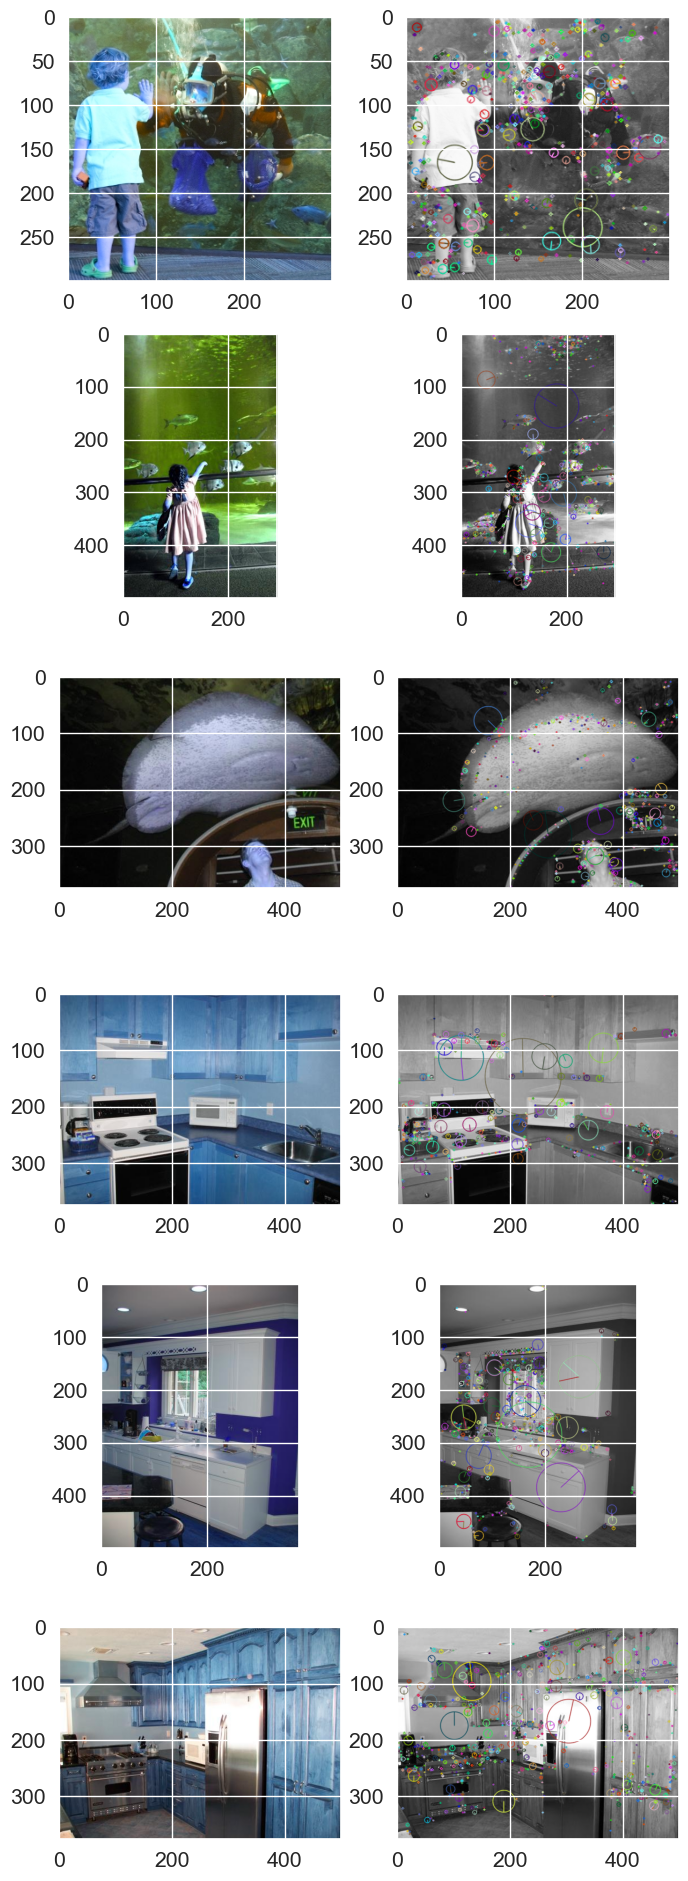

In [ ]:
n = len(images_path)

fig, axs = plt.subplots(n, 2, figsize=(8, 4*n))

for i, image_path in zip(range(n), images_path):
    axs[i, 0].imshow(cv2.imread(image_path))
    axs[i, 1].imshow(sift_descript(image_path))
plt.show()

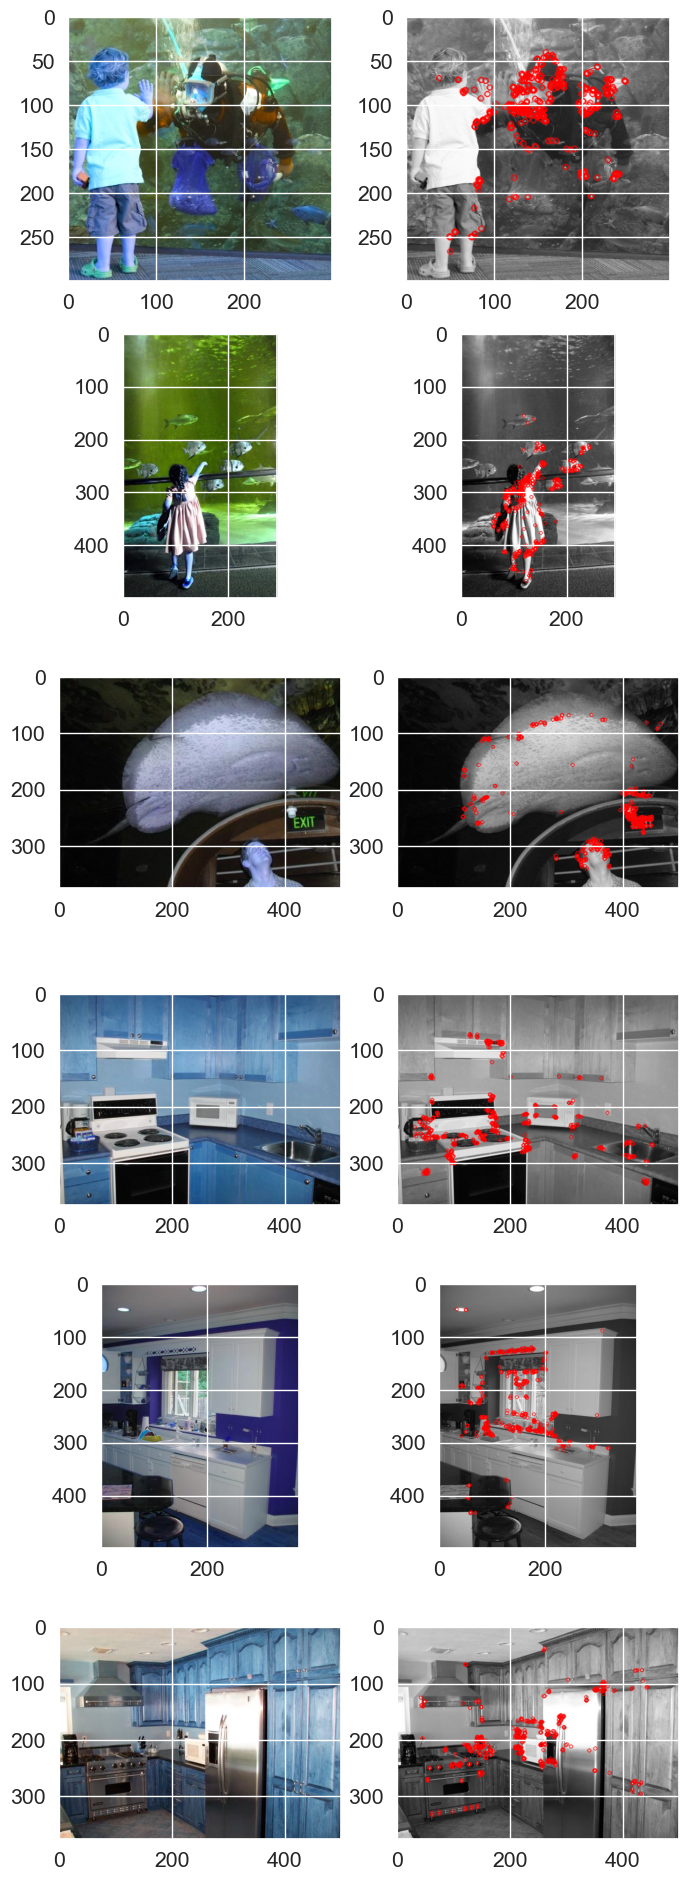

In [ ]:
fig, axs = plt.subplots(n, 2, figsize=(8, 4*n))

for i, image_path in zip(range(n), images_path):
    axs[i, 0].imshow(cv2.imread(image_path))
    axs[i, 1].imshow(orb_descript(image_path))

plt.show()

In [ ]:
# DOESN'T WORK CAUSE IT'S PATTENTED
'''
img_path = os.path.join(lab4_path,"aquarium/sun_acjrhiyqadrbtovi.jpg"),
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

surf = cv2.xfeatures2d.SURF_create(400)
kp = surf.detect(img, None)

img = cv2.drawKeypoints(gray, kp, None, (255, 0, 0), 4)

plt.imshow(img)
'''

'\nimg_path = os.path.join(lab4_path,"aquarium/sun_acjrhiyqadrbtovi.jpg"),\nimg = cv2.imread(image_path)\ngray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n\nsurf = cv2.xfeatures2d.SURF_create(400)\nkp = surf.detect(img, None)\n\nimg = cv2.drawKeypoints(gray, kp, None, (255, 0, 0), 4)\n\nplt.imshow(img)\n'

### (Optional) Exercise 4.5: Implement other image descriptor methods (motion, shape, ...)


### Exercise 5: Bag of Visual Words Pipeline and VOC Dataset Analysis
**Objective**:
Develop a BoVW model and apply it to classify images from the VOC dataset, focusing on the BoVW approach.

**Guideline**:
- Load the VOC dataset.
- Implement the BoVW model.
- Apply the model to the dataset for classification.
- Evaluate the model's performance.

**Expected Results**:
- Implementation of the Bag of Visual Words model.
- Application of the model for image classification.
- Evaluation of the model's performance.

**Optional Enhancements**:
- Experiment with different clustering algorithms for codebook generation in the BoVW model.

### Step 1: Data Loading
- **Objective**: Load images from each class into a format suitable for processing.
- **Guide**: Use a library like OpenCV or PIL in Python to load images. Iterate over the folders, loading each image and storing it with its class label.

In [ ]:
def folder_iteration(path, dataframe):
    directory = path

    for file in os.listdir(directory):
        p = os.path.join(directory, file)

        if os.path.isdir(p):
            dataframe = folder_iteration(p, dataframe)
        elif os.path.isfile(p):
            img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            label = os.path.basename(directory)
            row = pd.DataFrame([[img, label]], columns=['Image', 'Label'])
            dataframe = pd.concat([dataframe, row], ignore_index = True)

    return dataframe



data = {}
dataset = pd.DataFrame(data)
folder_path = os.path.join(lab4_path, 'dataset/train')
dataset = folder_iteration(folder_path, dataset)
dataset.dropna(inplace=True)
dataset.reset_index(inplace=True, drop=True)
dataset.head()

,Image,Label
0,"[[144, 165, 185, 176, 208, 182, 188, 178, 178,...",waterfall
1,"[[90, 87, 91, 91, 91, 92, 88, 92, 91, 91, 91, ...",waterfall
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",waterfall
3,"[[93, 93, 94, 96, 97, 98, 99, 100, 101, 102, 1...",waterfall
4,"[[155, 164, 168, 163, 156, 154, 152, 151, 153,...",waterfall


### Step 2: Feature Extraction
- **Objective**: Extract features from each image to represent its content.
- **Guide**: Apply a feature descriptor to each image. This transforms the image into a set of features. Examples can be SIFT, SURF, Color histogram, etc

In [ ]:
def feature_extract(exctractor, image):
    kp, desc = exctractor.detectAndCompute(image, None)
    return kp, desc

image_features_train = []
image_features_dataframe = []
sift_extractor = cv2.SIFT_create()
for index, row in dataset.iterrows():
    kp, desc = feature_extract(sift_extractor, row['Image'])
    image_features_train.extend(desc)
    image_features_dataframe.append(desc)

dataset['Features'] = image_features_dataframe

dataset.head()

,Image,Label,Features
0,"[[144, 165, 185, 176, 208, 182, 188, 178, 178,...",waterfall,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[90, 87, 91, 91, 91, 92, 88, 92, 91, 91, 91, ...",waterfall,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0,..."
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",waterfall,"[[19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 3.0..."
3,"[[93, 93, 94, 96, 97, 98, 99, 100, 101, 102, 1...",waterfall,"[[18.0, 5.0, 4.0, 0.0, 1.0, 3.0, 2.0, 11.0, 22..."
4,"[[155, 164, 168, 163, 156, 154, 152, 151, 153,...",waterfall,"[[45.0, 25.0, 50.0, 14.0, 0.0, 0.0, 0.0, 2.0, ..."


### Step 3: Building the Vocabulary (Codebook)
- **Objective**: Create a vocabulary of visual words (features) that represents the dataset.
- **Guide**: Cluster the extracted features across all images using any clustering algorithm. Each cluster center is a visual word.

In [ ]:
from sklearn.cluster import KMeans

def kmeans(k_num, features):
    kmeans_model = KMeans(k_num, n_init=10)

    kmeans_model.fit(features)

    return kmeans_model

km_model = kmeans(10, image_features_train)

### Step 4: Feature Encoding
- **Objective**: Encode each image as a frequency histogram of visual words.
- **Guide**: For each image, count how many features fall into each cluster (visual word) and create a histogram.

In [ ]:
from collections import Counter
def histograms(km_model, dataset):

    histograms = []
    for key, row in dataset.iterrows():
        predictions = []
        dummys = []
        for feature in row['Features']:
            dummy = np.array(feature, dtype=float)
            dummys.append(dummy)

        predictions = km_model.predict(dummys)
        histogram = np.zeros(len(km_model.cluster_centers_), dtype=int)
        count = Counter(predictions)

        for key in count:
            histogram[key - 1] = count[key]

        histograms.append(histogram)

    dataset['Histogram'] = histograms

    return dataset

#dataset['Features'].head()
dataset = histograms(km_model, dataset)
dataset.head()

,Image,Label,Features,Histogram
0,"[[144, 165, 185, 176, 208, 182, 188, 178, 178,...",waterfall,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[31, 30, 61, 87, 23, 20, 47, 33, 32, 16]"
1,"[[90, 87, 91, 91, 91, 92, 88, 92, 91, 91, 91, ...",waterfall,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0,...","[41, 26, 47, 67, 29, 13, 48, 31, 24, 22]"
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",waterfall,"[[19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 3.0...","[55, 90, 70, 113, 107, 111, 37, 92, 109, 25]"
3,"[[93, 93, 94, 96, 97, 98, 99, 100, 101, 102, 1...",waterfall,"[[18.0, 5.0, 4.0, 0.0, 1.0, 3.0, 2.0, 11.0, 22...","[50, 44, 89, 108, 46, 32, 72, 45, 49, 26]"
4,"[[155, 164, 168, 163, 156, 154, 152, 151, 153,...",waterfall,"[[45.0, 25.0, 50.0, 14.0, 0.0, 0.0, 0.0, 2.0, ...","[36, 44, 34, 95, 39, 30, 14, 41, 35, 11]"


### Step 5: Classifier Training
- **Objective**: Train a machine learning model to classify the images.
- **Guide**: Use the histograms as input features for a classifier. Any supervised classifier can be used (SVM, Random Forest, KNN, Neural nets, ...)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

#X = dataset['Histogram']
X = pd.DataFrame.from_dict(dict(zip(dataset['Histogram'].index, dataset['Histogram'].values))).T
y = dataset['Label']

classifier = RandomForestClassifier()
classifier.fit(X, y)


RandomForestClassifier()

In [ ]:

data = {}
dataset_test = pd.DataFrame(data)
folder_path = os.path.join(lab4_path, 'dataset/test')
dataset_test = folder_iteration(folder_path, dataset_test)
dataset_test.dropna(inplace=True)
dataset_test.head()

image_features_train = []
image_features_dataframe = []
sift_extractor = cv2.SIFT_create()
for index, row in dataset_test.iterrows():
    kp, desc = feature_extract(sift_extractor, row['Image'])
    image_features_train.extend(desc)
    image_features_dataframe.append(desc)

dataset_test['Features'] = image_features_dataframe

dataset_test = histograms(km_model, dataset_test)
dataset_test.reset_index(drop=True, inplace=True)
dataset_test.head()



,Image,Label,Features,Histogram
0,"[[124, 64, 111, 143, 132, 33, 44, 93, 70, 95, ...",waterfall,"[[73.0, 13.0, 22.0, 29.0, 86.0, 38.0, 5.0, 12....","[183, 182, 251, 105, 210, 238, 57, 267, 277, 129]"
1,"[[25, 25, 27, 30, 32, 31, 28, 25, 25, 25, 24, ...",waterfall,"[[3.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0,...","[220, 186, 314, 238, 208, 164, 239, 193, 225, 92]"
2,"[[60, 116, 121, 56, 63, 68, 82, 83, 66, 79, 92...",waterfall,"[[25.0, 13.0, 44.0, 23.0, 14.0, 22.0, 5.0, 26....","[194, 146, 267, 131, 135, 205, 180, 177, 214, ..."
3,"[[45, 27, 19, 16, 11, 18, 33, 37, 15, 17, 20, ...",waterfall,"[[12.0, 25.0, 11.0, 19.0, 70.0, 73.0, 22.0, 7....","[146, 217, 169, 101, 199, 457, 137, 200, 178, 73]"
4,"[[145, 145, 145, 145, 145, 145, 145, 145, 147,...",waterfall,"[[0.0, 5.0, 119.0, 78.0, 6.0, 4.0, 3.0, 0.0, 3...","[40, 47, 32, 217, 47, 31, 44, 65, 60, 23]"


In [ ]:
X_test = pd.DataFrame.from_dict(dict(zip(dataset_test['Histogram'].index, dataset_test['Histogram'].values))).T
y_test = dataset_test['Label']

y_pred = classifier.predict(X_test)

### Step 6: Model Evaluation
- **Objective**: Evaluate the performance of the classifier.
- **Guide**: Use a confusion matrix to visualize the performance and extract metrics.

0.4


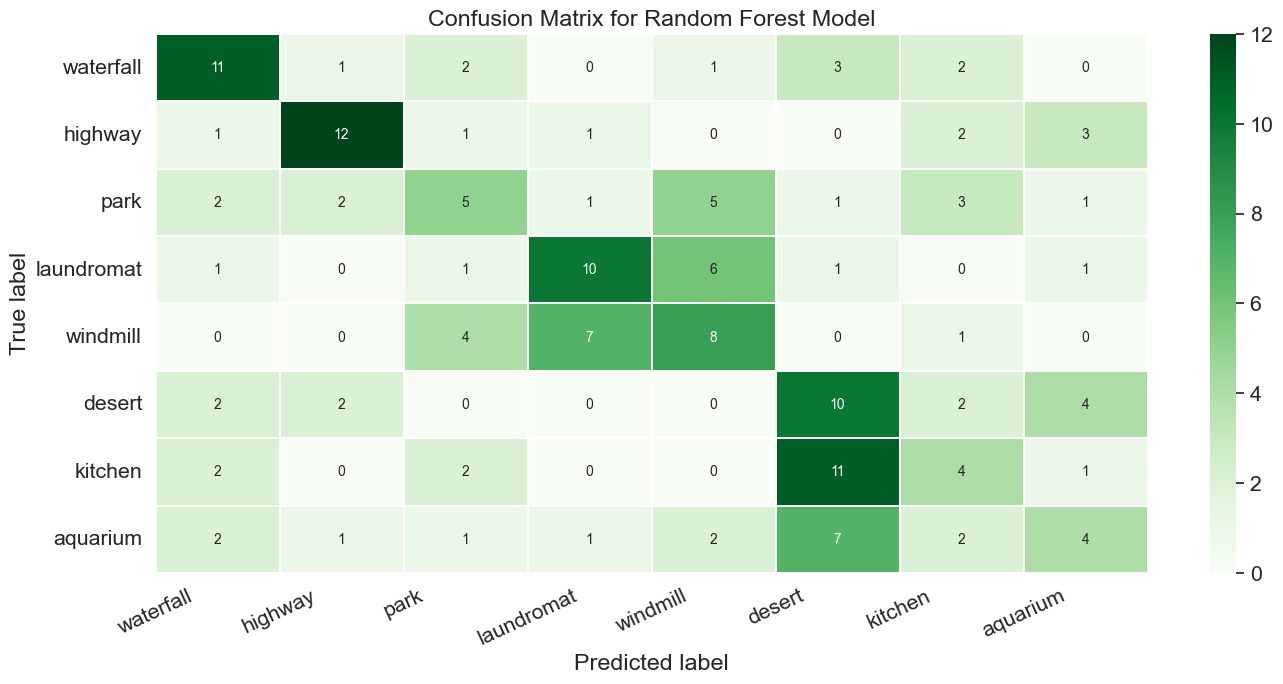

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = dataset_test['Label'].unique()
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

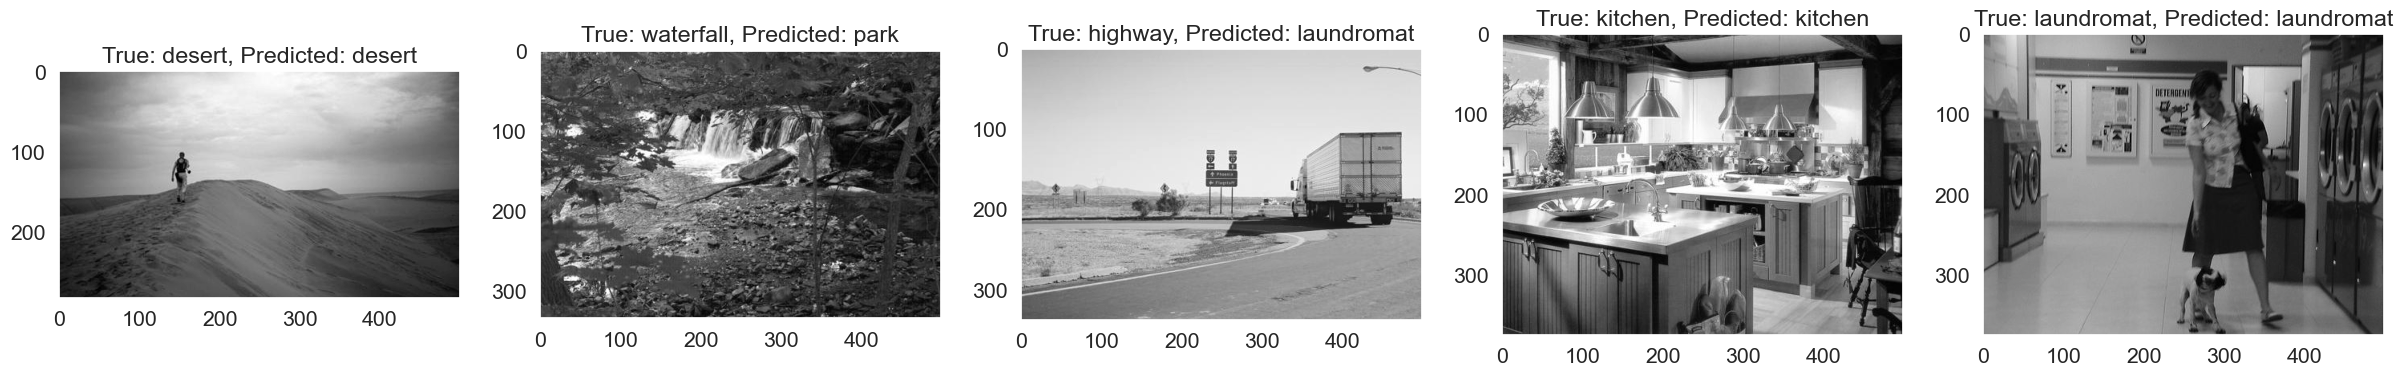

In [ ]:
import random
n = 5
samples = random.sample(range(160), n)

fig, axs = plt.subplots(1, n, figsize=(6*n, 6))
for i, sample in zip(range(n), samples):
    axs[i].imshow(dataset_test['Image'].iloc[sample], cmap='gray')
    axs[i].title.set_text(f'True: {y_test[sample]}, Predicted: {y_pred[sample]}')
    axs[i].grid(None)

plt.show()